In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import seaborn as sn
import pandas as pd

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
torch.manual_seed(0)

dataset_location = 'C:\\Users\\Callum\\Documents\\Datasets'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

MNIST_train = torchvision.datasets.MNIST(dataset_location, train=True, transform=transform,
                           target_transform=None, download=True)

MNIST_test = torchvision.datasets.MNIST(dataset_location, train=False, transform=transform,
                           target_transform=None, download=True)

class1 = 1
class2 = 3

classes = [class1, class2]

indices_train = torch.tensor([], dtype=torch.uint8)
for c in classes:
    class_indices = (MNIST_train.train_labels == c).nonzero()
    class_indices = class_indices.reshape([class_indices.size(0)])
    indices_train = torch.cat((indices_train, class_indices))

indices_test = torch.tensor([], dtype=torch.uint8)
for c in classes:
    class_indices = (MNIST_test.train_labels == c).nonzero()
    class_indices = class_indices.reshape([class_indices.size(0)])
    indices_test = torch.cat((indices_test, class_indices))
    
train_data = torch.utils.data.Subset(MNIST_train, indices_train)
test_data = torch.utils.data.Subset(MNIST_test, indices_test)

# train_data = torch.utils.data.Subset(train_data, [1, 9001])

print('{} training pictures, {} test pictures'.format(len(train_data), len(test_data)))

12873 training pictures, 2145 test pictures


C:\Users\Callum\anaconda3\envs\CI\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
<ipython-input-3-ec871c0f4a3e>:22: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  class_indices = (MNIST_train.train_labels == c).nonzero()


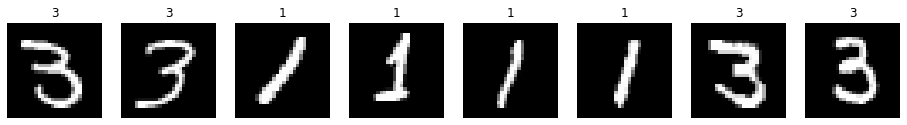

In [4]:
batch_size = 64
num_threads = 8

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_threads)

(data, labels) = next(iter(train_loader))

f, axarr = plt.subplots(1, 8, figsize=(16, 2))
for i in range(min(8, data.size(0))):
    axarr[i].imshow(data[i][0], cmap='gray')
    axarr[i].set_title('{}'.format(labels[i]))
    axarr[i].axis('off')

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
    def forward(self, y0):
        y1 = F.relu(self.linear1(y0))
        y2 = F.relu(self.linear2(y1))
        y3 = torch.sigmoid(self.linear3(y2))
        return y3

#equivalent to the following except the pytroch implementation works on the GPU:
# def criterion(out, label):
#     return ((label - output)**2).mean()
criterion = nn.MSELoss()

#0.08
learning_rate = 0.05

network = MLP(28 * 28, 10, 1).to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.3)

graph_loss = []
graph_accuracy = []
graph_confidence = []

graph_epoch = []
num_batches = len(train_data) /float(batch_size)

confusion_matrix = [[0, 0], [0, 0]]

def evaluate(print_accuracy, print_images):
    with torch.no_grad():
        right = 0
        wrong = 0
        for batch_num, (data, labels) in enumerate(test_loader):

            data_input = data.to(device)
            data_input = data_input.reshape([data.size()[0], 28 * 28])

            labels = labels.to(device)
            labels[labels == class1] = 0
            labels[labels == class2] = 1

            outputs = network(data_input)
            outputs = outputs.reshape([outputs.size(0)])

            wrong_in_batch = len((outputs.round() - labels.float()).nonzero())
            
            right += data.size(0) - wrong_in_batch
            wrong += wrong_in_batch
            
            outputs_rounded = outputs.round()
            
            for i in range(labels.size(0)):
                if labels[i] < 0.5 and outputs_rounded[i] < 0.5:
                    confusion_matrix[0][0] += 1
                if labels[i] > 0.5 and outputs_rounded[i] > 0.5:
                    confusion_matrix[1][1] += 1
                if labels[i] < 0.5 and outputs_rounded[i] > 0.5:
                    confusion_matrix[0][1] += 1
                if labels[i] > 0.5 and outputs_rounded[i] < 0.5:
                    confusion_matrix[1][0] += 1

            if batch_num == 0 and print_images:
                # P=predicted, A=actual
                f, axarr = plt.subplots(1, 8, figsize=(16, 2))
                for i in range(8):
                    axarr[i].imshow(data[i][0], cmap='gray')
                    axarr[i].set_title('P: {} A: {}'.format(class1 if outputs.round()[i] == 0 else class2, class1 if labels[i] == 0 else class2))
                    axarr[i].axis('off')
                if not print_accuracy:
                    break

        if print_accuracy:
            print('{} right {} wrong {:.0f}% accuracy'.format(right, wrong, right / (right + wrong) * 100.0))

def trainNetwork():
    for epoch in range(1):
        for batch_num, (data, labels) in enumerate(train_loader):
            
            data = data.to(device)
            data = data.reshape([data.size()[0], 28 * 28])
            
#             for i in range(10000):
            
            optimizer.zero_grad()

            outputs = network(data)
            outputs = outputs.reshape([outputs.size(0)])

            labels = labels.to(device)
            labels[labels == class1] = 0
            labels[labels == class2] = 1
            labels = labels.float()

            outputs_rounded = outputs.round()

            wrong_in_batch = len((outputs_rounded - labels).nonzero())

            loss = criterion(outputs, labels)
            loss.backward()

            graph_loss.append(loss.item())
            graph_accuracy.append((labels.size(0) - wrong_in_batch) / labels.size(0))
            graph_epoch.append((batch_num / num_batches) + epoch)
            graph_confidence.append(torch.mean(torch.abs(outputs - 0.5) / 0.5))

            optimizer.step()
            
        print('epoch {} done'.format(epoch + 1))
        evaluate(True, False)

print("Network:")
trainNetwork()

Network:
epoch 1 done
2127 right 18 wrong 99% accuracy


In [6]:
# evaluate(True, True)

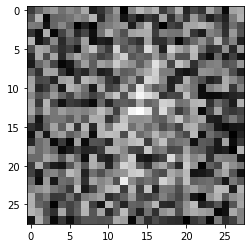

In [7]:
def test(x):
    x = 0

with torch.no_grad():
    w1 = network.linear1.weight.clone()
    w1 = w1.reshape([w1.size(0), 28, 28])
    
    w = w1[0]
    
    w -= torch.min(w)
    w /= torch.max(w)

    plt.imshow(w.cpu(), cmap="gray")

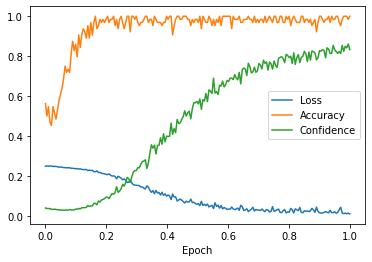

In [8]:
plt.xlabel("Epoch")

plt.plot(graph_epoch, graph_loss, label="Loss")
plt.plot(graph_epoch, graph_accuracy, label="Accuracy")
plt.plot(graph_epoch, graph_confidence, label="Confidence")

plt.legend()

[[1128, 7], [11, 999]]


<AxesSubplot:>

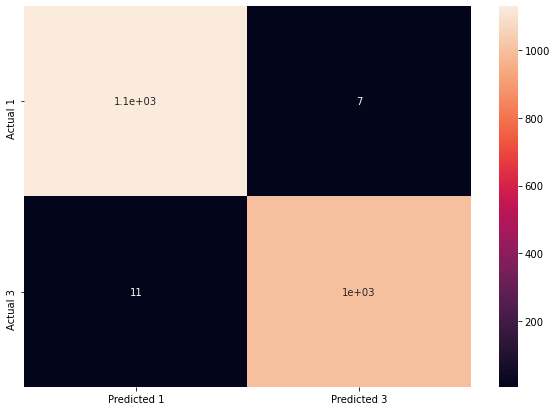

In [9]:
print(confusion_matrix)
df_cm = pd.DataFrame(confusion_matrix, ["Actual {}".format(class1), "Actual {}".format(class2)], ["Predicted {}".format(class1), "Predicted {}".format(class2)])
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)